# Evaluación Final MOD3 - Mar Pastor
---

### Ejercicio EDA y Vizualización de datos

En este ejercicio usaremos datos que consisten en dos BBDD de tipo CSV que contienen datos que describen el comportamiento de los clientes dentro de un programa de lealtad de una aerolínea.

Exploraremos los archivos:

- `Customer Flight Activity.csv` que contiene información sobre la actividad de vuelo de los clientes
- `Customer Loyalty History.csv` que proporciona un perfil detallado de los clientes y detalles sobre su membresía en el programa de lealtad
---

In [590]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
#import scipy.stats as stats
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest

# Configuración
# ------------------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [591]:
# abrimos los DataFrame:

df_flight = pd.read_csv('../data/Customer Flight Activity.csv')
df_loyalty = pd.read_csv('../data/Customer Loyalty History.csv')

### Se decide trabajar cada DataFrame de forma individual para la exploracion y limpieza de datos, para luego realizar la unión de ambos

## I. Trabajamos con el DataFrame de información sobre la actividad de vuelo de los clientes
#### DataFrame: `df_flight`
---

In [592]:
# 1. Exploramos una visión general del DataFrame:

display(df_flight.head(2)) # revisamos los primeros datos
print('***' * 50)
display(df_flight.tail(2)) # revisamos los últimos datos
print('***' * 50)
display(df_flight.sample(2)) # revisamos datos aleatorios

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0


******************************************************************************************************************************************************


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
405622,999982,2018,12,0,0,0,0,0.0,0,0
405623,999986,2018,12,0,0,0,0,0.0,0,0


******************************************************************************************************************************************************


,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
133842,927165,2017,8,0,0,0,0,0.0,0,0
60615,626664,2017,4,14,0,14,1358,135.0,0,0


In [593]:
# exploramos el número de filas y columnas:
 
print(f"El número de filas es {df_flight.shape[0]}, el número de columnas es {df_flight.shape[1]}")

El número de filas es 405624, el número de columnas es 10


In [594]:
# exploramos los nombres de las columnas:

df_flight.columns

# vemos que hay un patrón consistente en el nombre de las columnas, por lo que no hacemos modificaciones

Index(['Loyalty Number', 'Year', 'Month', 'Flights Booked',
       'Flights with Companions', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed'],
      dtype='object')

In [595]:
# 2. Exploramos la información del DataFrame:

df_flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB


### Primeras conclusiones de la exploración de datos del DataFrame:

- No existen datos nulos, por lo que no haremos ninguna modificación
- Las columnas tienen nombres unificados, por lo que no haremos cambios
- La columna 'Points Accumulated' tiene un tipo de dato 'float' y luego de la exploración inicial podríamos unificar los datos y cambiarlo a 'entero'
- La columna 'Year' la convertimos en object para tratarla como una columna categórica

In [596]:
# convertir dato 'float' a 'int' en la columna 'Points Accumulated'

df_flight['Points Accumulated'] = df_flight['Points Accumulated'].astype(int)

df_flight.info() # para comprobar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   Loyalty Number               405624 non-null  int64
 1   Year                         405624 non-null  int64
 2   Month                        405624 non-null  int64
 3   Flights Booked               405624 non-null  int64
 4   Flights with Companions      405624 non-null  int64
 5   Total Flights                405624 non-null  int64
 6   Distance                     405624 non-null  int64
 7   Points Accumulated           405624 non-null  int32
 8   Points Redeemed              405624 non-null  int64
 9   Dollar Cost Points Redeemed  405624 non-null  int64
dtypes: int32(1), int64(9)
memory usage: 29.4 MB


In [597]:
# convertir dato 'int' a 'object' en la columna 'Year'

df_flight['Year'] = df_flight['Year'].astype('object')

df_flight.info() # para verificar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Loyalty Number               405624 non-null  int64 
 1   Year                         405624 non-null  object
 2   Month                        405624 non-null  int64 
 3   Flights Booked               405624 non-null  int64 
 4   Flights with Companions      405624 non-null  int64 
 5   Total Flights                405624 non-null  int64 
 6   Distance                     405624 non-null  int64 
 7   Points Accumulated           405624 non-null  int32 
 8   Points Redeemed              405624 non-null  int64 
 9   Dollar Cost Points Redeemed  405624 non-null  int64 
dtypes: int32(1), int64(8), object(1)
memory usage: 29.4+ MB


In [598]:
# convertir dato 'int' a 'object' en la columna 'Month'

df_flight['Month'] = df_flight['Month'].astype('str')

df_flight.info() # para verificar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Loyalty Number               405624 non-null  int64 
 1   Year                         405624 non-null  object
 2   Month                        405624 non-null  object
 3   Flights Booked               405624 non-null  int64 
 4   Flights with Companions      405624 non-null  int64 
 5   Total Flights                405624 non-null  int64 
 6   Distance                     405624 non-null  int64 
 7   Points Accumulated           405624 non-null  int32 
 8   Points Redeemed              405624 non-null  int64 
 9   Dollar Cost Points Redeemed  405624 non-null  int64 
dtypes: int32(1), int64(7), object(2)
memory usage: 29.4+ MB


In [599]:
# convertimos los numeros de los meses por los nombre de los meses para mejor comprensión
# usamos una diccionario-mascara que asigna a cada numero un nombre de mes, que luego aplicamos con un replace

mapa_mes = {'1': 'Enero', '2': 'Febrero', '3': 'Marzo', '4': 'Abril', '5': 'Mayo', '6': 'Junio', 
            '7': 'Julio', '8': 'Agosto', '9': 'Septiembre', '10': 'Octubre', '11': 'Noviembre', '12': 'Diciembre'}

df_flight['Month'] = df_flight['Month'].map(mapa_mes) # usamos 'map' porque verificamos que no tenemos valores nulos en esta columna
df_flight['Month'].unique() # para verificar los cambios

array(['Enero', 'Septiembre', 'Febrero', 'Marzo', 'Noviembre', 'Abril',
       'Mayo', 'Julio', 'Junio', 'Agosto', 'Octubre', 'Diciembre'],
      dtype=object)

In [600]:
# 3. Exploramos los datos de las columnas categóricas usando 'describe()'

df_flight.describe(include='O').T

,count,unique,top,freq
Year,405624,2,2017,202812
Month,405624,12,Enero,33802


In [601]:
# exploramos los datos de las columnas numéricas usando describe()

df_flight.describe().T

# concluímos que las media y la mediana no están cercanas en muchos de los datos de algunas columnas, 
# y en algunas columnas la dispersión de los datos es alta

,count,mean,std,min,25%,50%,75%,max
Loyalty Number,405624.0,550037.873084,258935.286969,100018.0,326961.0,550834.0,772194.0,999986.0
Flights Booked,405624.0,4.115052,5.225518,0.0,0.0,1.0,8.0,21.0
Flights with Companions,405624.0,1.031805,2.076869,0.0,0.0,0.0,1.0,11.0
Total Flights,405624.0,5.146858,6.521227,0.0,0.0,1.0,10.0,32.0
Distance,405624.0,1208.880059,1433.155320,0.0,0.0,488.0,2336.0,6293.0
Points Accumulated,405624.0,123.667002,146.579083,0.0,0.0,50.0,239.0,676.0
Points Redeemed,405624.0,30.696872,125.486049,0.0,0.0,0.0,0.0,876.0
Dollar Cost Points Redeemed,405624.0,2.484503,10.150038,0.0,0.0,0.0,0.0,71.0


In [602]:
# 4. Exploramos el DataFrame para detectar registros duplicados

df_flight.duplicated().sum() 
# se registran 1864 entradas de datos duplicadas

1864

In [603]:
mascara = df_flight.duplicated(keep=False) # mantenemos visible las entradas originales y las duplicadas
df_flight[mascara].sort_values('Loyalty Number') # aplicamos la mascara para la columna de los id de los clientes que deben ser unicos

# comprobamos que los clientes se repiten en los registros en diferentes meses y sin ningun otro dato registrado

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
41,101902,2017,Enero,0,0,0,0,0,0,0
33843,101902,2017,Marzo,0,0,0,0,0,0,0
16942,101902,2017,Febrero,0,0,0,0,0,0,0
185952,101902,2017,Diciembre,0,0,0,0,0,0,0
185953,101902,2017,Diciembre,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
354784,992168,2018,Septiembre,0,0,0,0,0,0,0
33665,992168,2017,Febrero,0,0,0,0,0,0,0
33664,992168,2017,Febrero,0,0,0,0,0,0,0
101269,992168,2017,Junio,0,0,0,0,0,0,0


In [604]:
# se crea una nueva variable con la mascara creada
mascara = df_flight.duplicated(keep=False)
duplicados = df_flight[mascara]

# se agrupa por 'Loyalty Number' y contamos cuántas veces aparece cada uno para explorar a profundidad
conteo_por_cliente = duplicados.groupby('Loyalty Number').size().reset_index(name='Cantidad Duplicados') # nueva columna

# se ordena por los que tienen más duplicados primero
conteo_por_cliente = conteo_por_cliente.sort_values(by='Cantidad Duplicados', ascending=False)
conteo_por_cliente

,Loyalty Number,Cantidad Duplicados
94,678205,52
60,467894,48
64,488224,48
114,762990,48
110,741848,48
...,...,...
67,499874,2
104,713132,2
1,106001,2
70,512296,2


In [605]:
# luego de visualizar todas las entradas duplicadas, se decide eliminar estos datos para que no nos afecte los siguientes análisis

# NOTA: Primero se verificó que habían muchas entradas con valores '0', lo que nos afectaba las visualizaciones de los datos
# Siguiendo este razonamiento se decide explorar los datos duplicados primero y luego de verificar que son clientes repetidos 
# múltiple veces y sin ningún registro en las demás columnas, se decide eliminar estos registros para que no afecten los siguientes análisis

# NOTA 2: Se le podría sugerir a la empresa que recoge los datos revisar el sistema de registro de clientes para no generar diferentes entradas
# para un mismo cliente, o generar alguna alerta cuando se intente registrar un cliente que ya existe en la base de datos

In [606]:
# se eliminan los datos duplicados 
df_flight.drop_duplicates(inplace=True)
df_flight.duplicated().sum() # para verificar que no tenemos duplicados en el DataFrame

0

In [607]:
# verificamos el total de filas de DataFrame
df_flight.info()

# el DataFram contenia originalmente 405.624 entradas, al elimnar los duplicados las entradas total quedan en 403.760
# 405.624 - 403.760 = 1.864 (datos duplicados detectados anteriormente)

<class 'pandas.core.frame.DataFrame'>
Index: 403760 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Loyalty Number               403760 non-null  int64 
 1   Year                         403760 non-null  object
 2   Month                        403760 non-null  object
 3   Flights Booked               403760 non-null  int64 
 4   Flights with Companions      403760 non-null  int64 
 5   Total Flights                403760 non-null  int64 
 6   Distance                     403760 non-null  int64 
 7   Points Accumulated           403760 non-null  int32 
 8   Points Redeemed              403760 non-null  int64 
 9   Dollar Cost Points Redeemed  403760 non-null  int64 
dtypes: int32(1), int64(7), object(2)
memory usage: 32.3+ MB


In [608]:
# 5. Análisis la variable categóricas, usando un 'value_count'

for col in df_flight.select_dtypes(include='O').columns:
    print(f"Columna --> {col}")
    print(f"{df_flight[col].value_counts()}")
    print('***' * 25)

# En el 2018 se realizaron mas vuelos
# Tenemos datos de los vuelos del 2018 y 2017
# El mes que mas se realizaron mas vuelos fue en 'Noviembre'

Columna --> Year
Year
2018    202022
2017    201738
Name: count, dtype: int64
***************************************************************************
Columna --> Month
Month
Noviembre     33663
Octubre       33662
Diciembre     33662
Septiembre    33659
Agosto        33655
Julio         33648
Junio         33646
Abril         33640
Mayo          33640
Marzo         33634
Febrero       33626
Enero         33625
Name: count, dtype: int64
***************************************************************************


In [609]:
# 6. Análisis de la variable numéricas, usando histograma y boxplot
# seleccionamos las columnas que nos interesan

df_flight.columns

Index(['Loyalty Number', 'Year', 'Month', 'Flights Booked',
       'Flights with Companions', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed'],
      dtype='object')

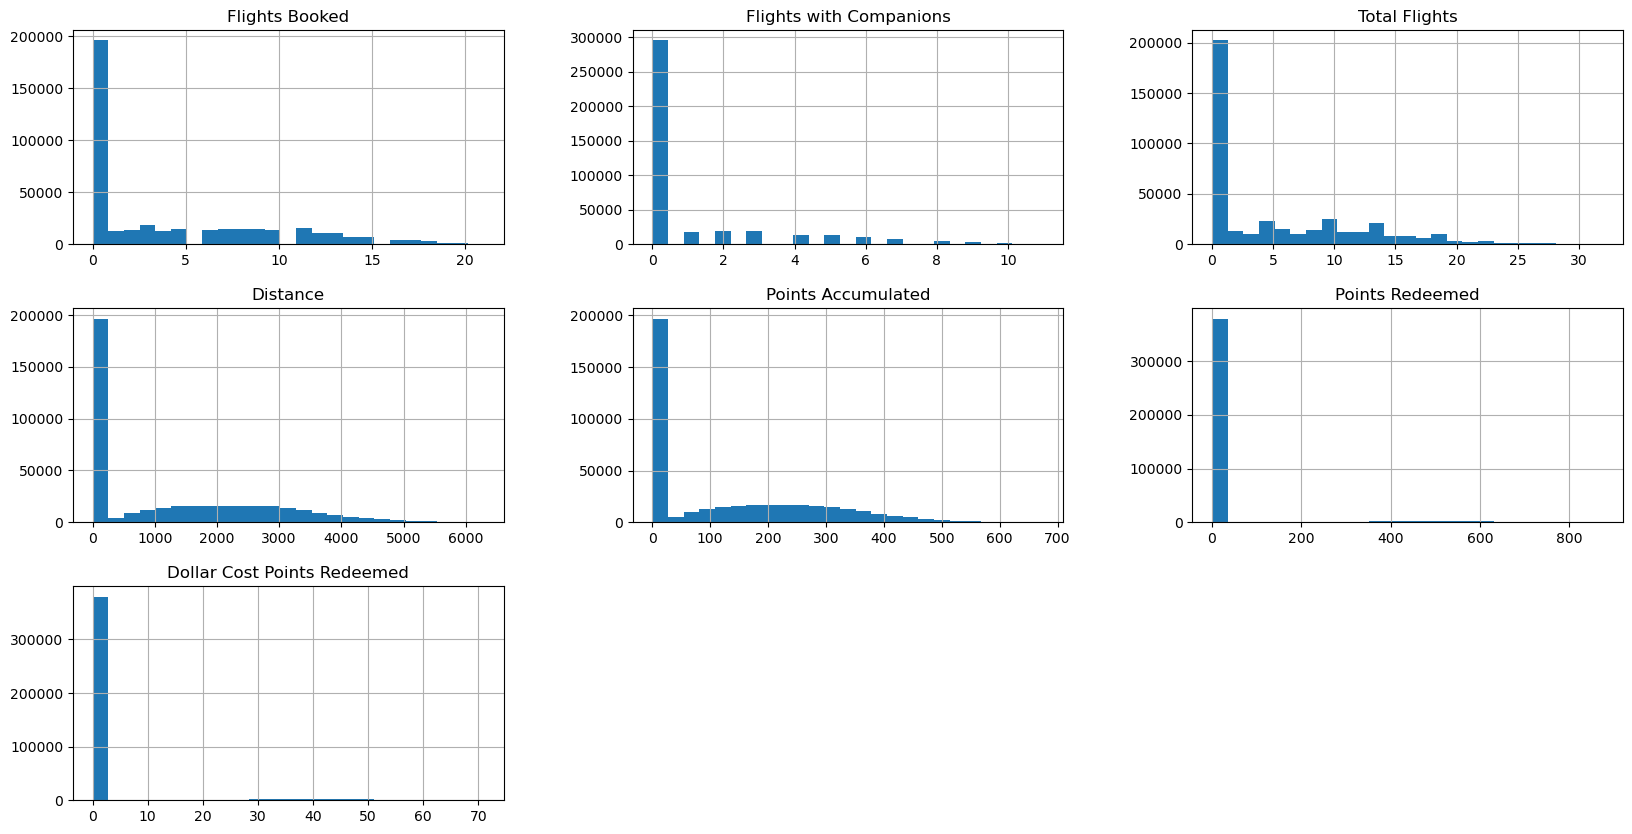

In [610]:
# se realiza un histograma para verificar la distribución de los datos en las columnas

df_flight[['Flights Booked', 'Flights with Companions', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed']].hist(bins=25, figsize=(20,10));

In [611]:
# en las gráficas anteriores vemos que los valores '0' distorcionan los datos, 
# ya que existe una cantidad de clientes en nuestra base de datos que no han registrado ningún vuelo aún

df_flight.head(20)

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,Enero,3,0,3,1521,152,0,0
1,100102,2017,Enero,10,4,14,2030,203,0,0
2,100140,2017,Enero,6,0,6,1200,120,0,0
3,100214,2017,Enero,0,0,0,0,0,0,0
4,100272,2017,Enero,0,0,0,0,0,0,0
5,100301,2017,Enero,0,0,0,0,0,0,0
6,100364,2017,Enero,0,0,0,0,0,0,0
7,100380,2017,Enero,0,0,0,0,0,0,0
8,100428,2017,Enero,6,0,6,606,60,0,0
9,100504,2017,Enero,0,0,0,0,0,0,0


In [612]:
# Creamos un DataFrame que filtre los 'clientes activos' para analizar mejor su actividad
# Lo filtramos por 'Total Flights', si no hay valores en esta columna no se registran datos en las demás columnas

df_flight_active = df_flight[df_flight['Total Flights'] > 0] # filtramos para que guarde registros mayores a '0'
df_flight_active.head(20)

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,Enero,3,0,3,1521,152,0,0
1,100102,2017,Enero,10,4,14,2030,203,0,0
2,100140,2017,Enero,6,0,6,1200,120,0,0
8,100428,2017,Enero,6,0,6,606,60,0,0
10,100550,2017,Enero,3,0,3,2037,203,0,0
11,863070,2017,Septiembre,8,7,15,4245,424,341,28
16,100727,2017,Enero,11,0,11,1144,114,0,0
18,100753,2017,Enero,8,4,12,3264,326,0,0
19,100816,2017,Enero,9,1,10,2340,234,0,0
20,100853,2017,Enero,6,6,12,1236,123,0,0


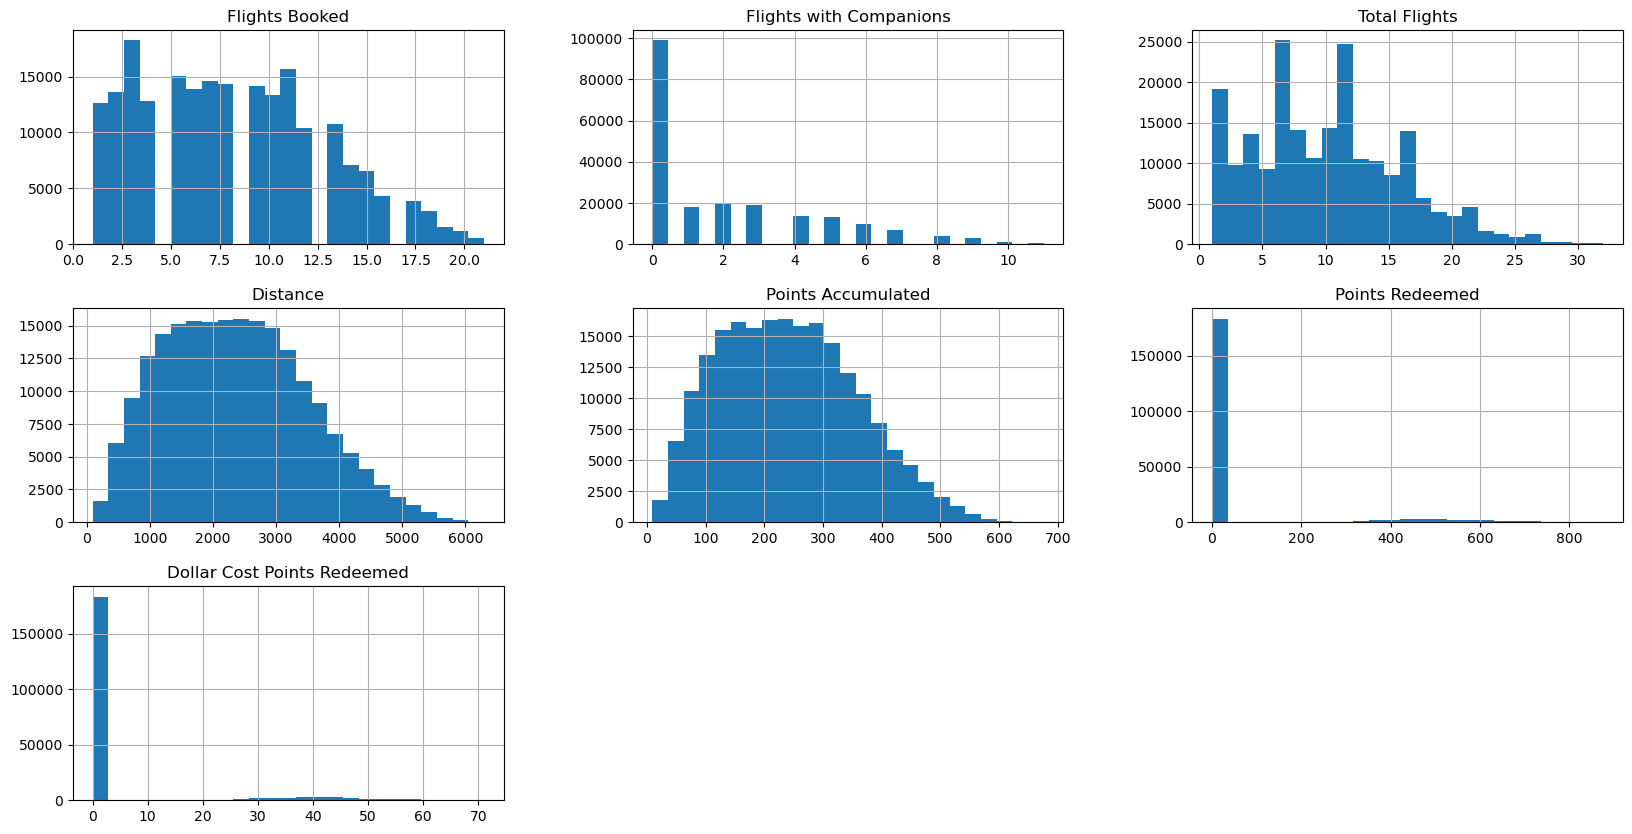

In [613]:
# con el DataFrame de 'clientes activos' podemos visualizar mejor las gráficas:

df_flight_active[['Flights Booked', 'Flights with Companions', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed']].hist(bins=25, figsize=(20,10));

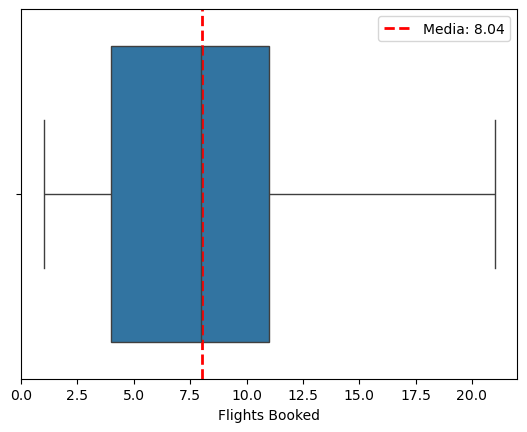

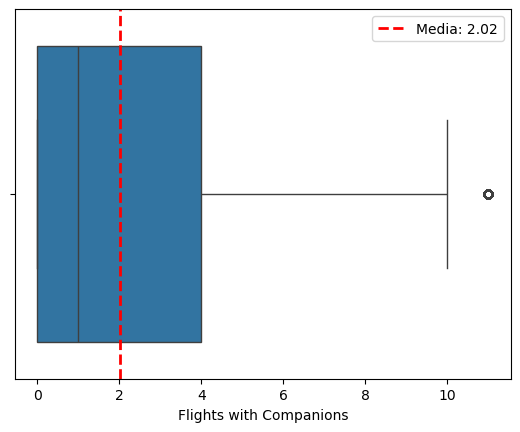

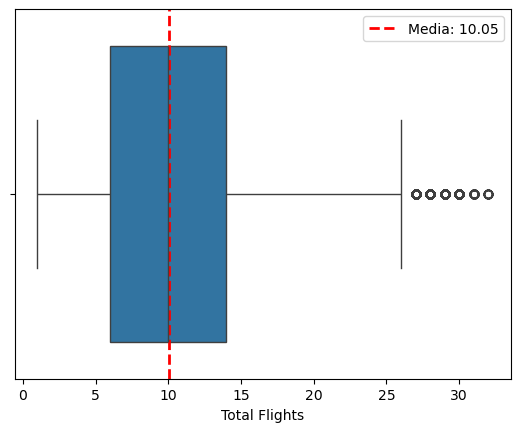

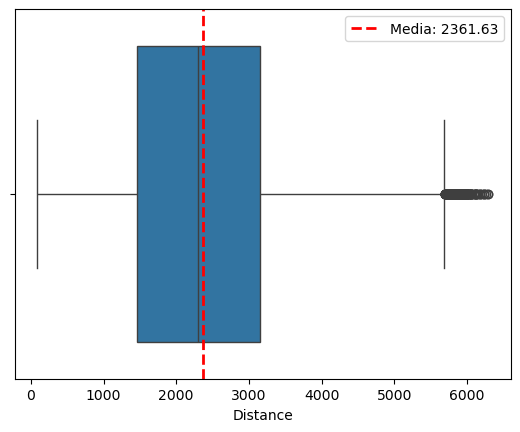

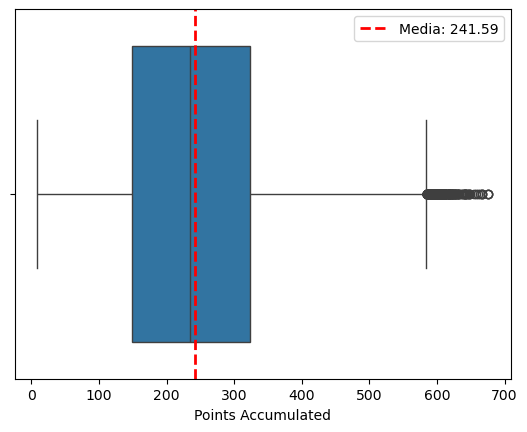

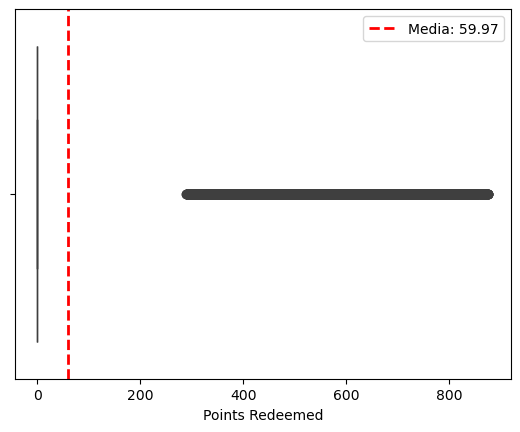

In [614]:
# usamos el DataFrame con los clientes filtrados (activos) y las columnas que nos aportan información:

for col in df_flight_active[['Flights Booked', 
                      'Flights with Companions', 
                      'Total Flights', 
                      'Distance',
                      'Points Accumulated',
                      'Points Redeemed']].columns:
    media_col = round(df_flight_active[col].mean(), 2) # se incorpora la media en el gráfico
    sns.boxplot(data=df_flight_active, x=col)
    plt.axvline(x=media_col, color='red', linestyle='--', linewidth=2, label=f'Media: {media_col}')
    plt.legend()
    plt.show();

### Algunas conclusiones:

- Vemos que muchos clientes tienen entre 4 y 11 vuelos que han sido reservados, que corresponde un poco con la grafica de 'Total vuelos' (entre 5 y 15 vuelos totales aproximadamente)
- La media de vuelos reservados es de 8 vuelos reservados por cliente, y vuelos totales 10. Se podría decir que la mayoría de vuelos reservados se realizan
- Menos clientes han realizado mas de 25 vuelos
- En su mayoría los vuelos han sido sin acompañantes (vuelos individuales) con una media de 2 vuelos
- La gran parte de los vuelos son de distancias cortas: entre 1.500 y 3.000. Pocos clientes han realizado vuelos mas largos
- Los clientes acumulan puntos por distancia de vuelo, entre 150 y 300 puntos (que se puede corresponder a la distancia de vuelo)
- Se puede concluir que la gran mayoría no han utilizado estos puntos acumulados por vuelos realizados, ya que la media de los puntos usados se encuentra en 500 (tomando en cuenta que la mayoría de clientes tiene entre 150 y 300 puntos actualmente, 240 de media)
- Se han realizado mas registros en 2018 comparado con 2017 (200 mas aproximadamente)
- El mes en el que mas se han registrado clientes ha sido 'Noviembre'

In [615]:
# 7. Se verifica la cantidad de nulos que tenemos en el DataFrame

df_flight.isnull().sum() 
# no tenemos datos nulos en ninguna de las columnas

Loyalty Number                 0
Year                           0
Month                          0
Flights Booked                 0
Flights with Companions        0
Total Flights                  0
Distance                       0
Points Accumulated             0
Points Redeemed                0
Dollar Cost Points Redeemed    0
dtype: int64

In [616]:
df_flight.info() # comprobar el total de registros. Tenemos el archivo limpio de duplicados y nulos

<class 'pandas.core.frame.DataFrame'>
Index: 403760 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Loyalty Number               403760 non-null  int64 
 1   Year                         403760 non-null  object
 2   Month                        403760 non-null  object
 3   Flights Booked               403760 non-null  int64 
 4   Flights with Companions      403760 non-null  int64 
 5   Total Flights                403760 non-null  int64 
 6   Distance                     403760 non-null  int64 
 7   Points Accumulated           403760 non-null  int32 
 8   Points Redeemed              403760 non-null  int64 
 9   Dollar Cost Points Redeemed  403760 non-null  int64 
dtypes: int32(1), int64(7), object(2)
memory usage: 32.3+ MB


## II. Trabajamos con el DataFrame de información sobre el perfil de los clientes y detalles de su membresía
#### DataFrame: `df_loyalty`
---

In [617]:
# 1. Exploramos una visión general del DataFrame:

display(df_loyalty.head(2)) # revisamos los primeros datos
print('***' * 50)
display(df_loyalty.tail(2)) # revisamos los últimos datos
print('***' * 50)
display(df_loyalty.sample(2)) # revisamos datos aleatorios

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN


******************************************************************************************************************************************************


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
16735,906428,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,-57297.0,Married,Star,10018.66,2018 Promotion,2018,4,NaN,NaN
16736,652627,Canada,Manitoba,Winnipeg,R2C 0M5,Female,Bachelor,75049.0,Married,Star,83325.38,Standard,2015,12,2016.0,8.0


******************************************************************************************************************************************************


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
8551,270935,Canada,Alberta,Peace River,T9O 2W2,Female,Bachelor,56870.0,Married,Nova,9422.97,Standard,2013,2,NaN,NaN
13946,972157,Canada,British Columbia,Vancouver,V6E 3Z3,Female,Bachelor,82772.0,Married,Star,5781.02,Standard,2016,6,NaN,NaN


In [618]:
# Primeras observaciones:
# vemos que hay algunos salarios en negativo y hay valores faltantes
# los datos de 'Enrollment Month' está en numero, se podría cambiar al nombre de los meses y tratar como una columna categórica
# faltan valores en la columna de 'Cancellation Year' y 'Cancellation Month', y estan de tipo 'float', se podría cambiar a 'int'
# 'Enrollment Type' tiene valores numéricos (año) y categóricos, se podría tratar como uan columnas de tipo categórico

In [619]:
# exploramos el número de filas y columnas:
 
print(f"El número de filas es {df_loyalty.shape[0]}, el número de columnas es {df_loyalty.shape[1]}")

El número de filas es 16737, el número de columnas es 16


In [620]:
# exploramos los nombres de las columnas:

df_loyalty.columns

# vemos que el patrón entre las columnas es consistente, por lo que no modificamos

Index(['Loyalty Number', 'Country', 'Province', 'City', 'Postal Code',
       'Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card',
       'CLV', 'Enrollment Type', 'Enrollment Year', 'Enrollment Month',
       'Cancellation Year', 'Cancellation Month'],
      dtype='object')

In [621]:
# 2. Exploramos la información del DataFrame:

df_loyalty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   float64
 15  Cancellation Month  2067 non-null   float64
dtypes: f

In [622]:
# Segundas observaciones:
# existen valores nulos en 'Salary', 'Cancellation Year, 'Cancellation Month'
# se puede considerar cambio valores a 'object/str' para los datos en 'Enrollment Year', 'Enrollment Month', 'Cancellation Year, 'Cancellation Month'

### Primeras conclusiones de la exploración de datos del DataFrame:

- Existen datos nulos que debemos gestionar antes de las visualizaciones en 'Salary', 'Cancellation Year, 'Cancellation Month' ✓
- Existen datos negativos en 'Salary' que debemos gestionar (no deberían haber salarios con valores negativos) ✓
- Las columnas tienen nombres unificados, por lo que no haremos cambios 
- Los datos en 'Enrollment Month' y 'Cancellation Month' están expresados en número de los meses. Se podría cambiar al nombre de los meses y tratar como una columna categórica ✓
- Los datos de las columnas 'Enrollment Year' y 'Enrollment Month' están de tipo 'int'. Se podría cambiar a 'object/str' y convertir a datos categóricos ✓
- Los datos de las columnas 'Cancellation Year' y 'Cancellation Month' están de tipo 'float'. Se decide cambiar de tipo de dato 'object/str' y convertir a datos categóricos ✓

In [623]:
# 3. Exploramos y gestionamos los valores nulos (gran cantidad de valores faltantes en el DataFrame y para que no afecte los análisis siguientes)

df_loyalty.isnull().sum()

# confirmamos que las columnas con datos nulos son 'Salary', 'Cancellation Year', 'Cancellation Month'

Loyalty Number            0
Country                   0
Province                  0
City                      0
Postal Code               0
Gender                    0
Education                 0
Salary                 4238
Marital Status            0
Loyalty Card              0
CLV                       0
Enrollment Type           0
Enrollment Year           0
Enrollment Month          0
Cancellation Year     14670
Cancellation Month    14670
dtype: int64

In [624]:
# para decidir como gestionar los nulos de estas columnas debemos verlo en porcentaje

df_loyalty.isnull().sum()/df_loyalty.shape[0]*100 # para verlo en porcentaje

Loyalty Number         0.000000
Country                0.000000
Province               0.000000
City                   0.000000
Postal Code            0.000000
Gender                 0.000000
Education              0.000000
Salary                25.321145
Marital Status         0.000000
Loyalty Card           0.000000
CLV                    0.000000
Enrollment Type        0.000000
Enrollment Year        0.000000
Enrollment Month       0.000000
Cancellation Year     87.650117
Cancellation Month    87.650117
dtype: float64

In [625]:
# podemos representar los nulos en un DataFrame, para mejor visualización que nos ayude a tomar decisiones

nulos = (df_loyalty.isnull().sum()/df_loyalty.shape[0]*100).reset_index() # guardamos los datos en porcentaje en una variable

nulos.rename(columns={'index': 'columna', 0:'% nulos'}, inplace=True) # reenombrar las columnas del nuevo DataFrame
mascara = nulos['% nulos'] > 0 # filtramos par que nos muestre los valores mayor a '0'
nulos = nulos[mascara]
nulos

,columna,% nulos
7,Salary,25.321145
14,Cancellation Year,87.650117
15,Cancellation Month,87.650117


In [626]:
# verificamos que 'Salary' tiene un 25% de nulos
# 'Cancellation Year' y 'Cancellation Month' tienen nulos con un 88%

# En ningún caso podemos imputar estos valores por la media/mediana, por lo que se debe generar una nueva categoría/valor:

# - 'No data' para los datos de cancelación, ya que podríamos determinar que estos clientes no han cancelado sus registro en el programa de lealtad

# - Para los datos de salario, ya que podemos intuir que el cliente no proporcionó este dato a la hora del registro, reemplazamos los valores nulos
# por el valor '0', que luedo podemos filtrar para los siguientes análisis

# Se debe tomar en cuenta que el tipo de dato de estas columnas se reemplazaran de numérico a categórico, 
# por lo que se aplicará la función 'replace()' y que el mapa no nos afecte estos datos nulos modificados

In [627]:
# visualizamos los datos en negativo que existen en la columna 'Salary' para ver si es un error de entrada, si son casos aislados
# determinar la razón

print(df_loyalty['Salary'].describe())
print(df_loyalty[df_loyalty['Salary'] < 0].head(20))
print(df_loyalty[df_loyalty['Salary'] < 0].count())

count     12499.000000
mean      79245.609409
std       35008.297285
min      -58486.000000
25%       59246.500000
50%       73455.000000
75%       88517.500000
max      407228.000000
Name: Salary, dtype: float64
       Loyalty Number Country          Province            City Postal Code  \
1082           542976  Canada            Quebec        Montreal     H2Y 4R4   
1894           959977  Canada  British Columbia       Vancouver     V5R 1W3   
2471           232755  Canada  British Columbia       Vancouver     V1E 4R6   
3575           525245  Canada  British Columbia        Victoria     V10 6T5   
3932           603070  Canada  British Columbia  West Vancouver     V6V 8Z3   
4712           491242  Canada  British Columbia    Dawson Creek     U5I 4F1   
6560           115505  Canada      Newfoundland      St. John's     A1C 6H9   
6570           430398  Canada      Newfoundland      St. John's     A1C 6H9   
7373           152016  Canada           Ontario         Toronto     P1J 8T7 

In [628]:
# convertimos los valores negativos en positivos usando la función 'abs'

df_loyalty['Salary'] = df_loyalty['Salary'].abs() 
df_loyalty.head(20)

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN
5,193662,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,51124.0,Married,Star,3844.57,Standard,2012,5,NaN,NaN
6,927943,Canada,Ontario,Toronto,P5S 6R4,Female,College,NaN,Single,Star,3857.95,Standard,2014,6,NaN,NaN
7,188893,Canada,Ontario,Trenton,K8V 4B2,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,12,NaN,NaN
8,852392,Canada,Quebec,Montreal,H2Y 2W2,Female,Bachelor,100159.0,Married,Star,3861.49,Standard,2015,5,NaN,NaN
9,866307,Canada,Ontario,Toronto,M8Y 4K8,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,10,NaN,NaN


In [629]:
df_loyalty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   float64
 15  Cancellation Month  2067 non-null   float64
dtypes: f

In [630]:
# primero verificamos la cantidad de nulos en la columna 'Salary'

df_loyalty['Salary'].isnull().sum()

4238

In [631]:
# imputamos los nulos con un nuevo valor '0' en la columna 'Salary'

df_loyalty['Salary'].value_counts(normalize=True)
df_loyalty['Salary'] = df_loyalty['Salary'].fillna(0)

# para verificar los cambios
print(df_loyalty['Salary'].isnull().sum()) # para obtener la suma total de nulos, si existe
display(df_loyalty.head(20)) # para ver el DataFrame y comprobar los datos

0


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,0.0,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,0.0,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,0.0,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN
5,193662,Canada,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,51124.0,Married,Star,3844.57,Standard,2012,5,NaN,NaN
6,927943,Canada,Ontario,Toronto,P5S 6R4,Female,College,0.0,Single,Star,3857.95,Standard,2014,6,NaN,NaN
7,188893,Canada,Ontario,Trenton,K8V 4B2,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,12,NaN,NaN
8,852392,Canada,Quebec,Montreal,H2Y 2W2,Female,Bachelor,100159.0,Married,Star,3861.49,Standard,2015,5,NaN,NaN
9,866307,Canada,Ontario,Toronto,M8Y 4K8,Male,Bachelor,100159.0,Married,Star,3861.49,Standard,2016,10,NaN,NaN


In [632]:
# convertimos los datos de float a int
# Recomendamos a la empresa: Para futuros registros estos deben ser ingresdaos en numeros enteros actualizando los valores '0'

df_loyalty['Salary'] = df_loyalty['Salary'].astype(int)
df_loyalty.info() # para comprobar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              16737 non-null  int32  
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   float64
 15  Cancellation Month  2067 non-null   float64
dtypes: f

In [633]:
# hacemos otra comprobación del DataFrame, de las columnas que nos quedan por gestionar

print(df_loyalty.isnull().sum())

Loyalty Number            0
Country                   0
Province                  0
City                      0
Postal Code               0
Gender                    0
Education                 0
Salary                    0
Marital Status            0
Loyalty Card              0
CLV                       0
Enrollment Type           0
Enrollment Year           0
Enrollment Month          0
Cancellation Year     14670
Cancellation Month    14670
dtype: int64


In [634]:
# comprobamos el tipo de datos de estas columnas
print(df_loyalty[['Cancellation Year', 'Cancellation Month']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cancellation Year   2067 non-null   float64
 1   Cancellation Month  2067 non-null   float64
dtypes: float64(2)
memory usage: 261.6 KB
None


In [635]:
# decidimos convertir los datos de float a int para luego convertirlo a object en las columnas 'Cancellation Year' y 'Cancellation Month'

df_loyalty[['Cancellation Year', 'Cancellation Month']] = df_loyalty[['Cancellation Year', 'Cancellation Month']].astype('Int64')
df_loyalty[['Cancellation Year', 'Cancellation Month']].info() # para comprobar el cambio

# el tipo 'Int64' considera los Nan antes de analizarlos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Cancellation Year   2067 non-null   Int64
 1   Cancellation Month  2067 non-null   Int64
dtypes: Int64(2)
memory usage: 294.3 KB


In [636]:
# imputamos los nulos con '0' que luego usaremos en el mapa de los nombres de los meses:

df_loyalty[['Cancellation Year', 'Cancellation Month']].value_counts(normalize=True)
df_loyalty[['Cancellation Year', 'Cancellation Month']] = df_loyalty[['Cancellation Year', 'Cancellation Month']].fillna(0)
print(df_loyalty[['Cancellation Year', 'Cancellation Month']].isnull().sum()) # para verificar los cambios

Cancellation Year     0
Cancellation Month    0
dtype: int64


In [637]:
# luego de gestionar los nulos en estas columnas, verificamos los datos neuvamente:

df_loyalty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              16737 non-null  int32  
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   16737 non-null  Int64  
 15  Cancellation Month  16737 non-null  Int64  
dtypes: I

In [638]:
# convertimos los datos de int a object en las columnas 'Enrollment Year' y 'Enrollment Month'

df_loyalty[['Enrollment Year', 'Enrollment Month', 'Cancellation Year', 'Cancellation Month']] = df_loyalty[['Enrollment Year', 'Enrollment Month', 'Cancellation Year', 'Cancellation Month']].astype(str)
df_loyalty[['Enrollment Year', 'Enrollment Month', 'Cancellation Year', 'Cancellation Month']].info() # para comprobar el cambio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Enrollment Year     16737 non-null  object
 1   Enrollment Month    16737 non-null  object
 2   Cancellation Year   16737 non-null  object
 3   Cancellation Month  16737 non-null  object
dtypes: object(4)
memory usage: 523.2+ KB


In [639]:
# convertimos los meses con el mapa que hicimos para el primer DataFrame

mapa_mes = {'0': 'Sin data', '1': 'Enero', '2': 'Febrero', '3': 'Marzo', '4': 'Abril', '5': 'Mayo', '6': 'Junio', 
            '7': 'Julio', '8': 'Agosto', '9': 'Septiembre', '10': 'Octubre', '11': 'Noviembre', '12': 'Diciembre'}

for col in df_loyalty[['Enrollment Month','Cancellation Month', 'Cancellation Year']].columns:
    df_loyalty[col] = df_loyalty[col].replace(mapa_mes)
    print(df_loyalty[col].unique())

# usamos 'replace' para que no afecte los valores nulos que tenemos en las columnas 'Cancellation Month', 'Cancellation Year'
# comprobamos que en las columnas de 'Enrollment Month' que no teníamos nulos, tenemos 12 nuevos datos con los nombres de los meses
# en cambio en 'Cancellation Month' tenemos nulos que se reemplazan por 'No data' (13 tipos de categorías)
# y en 'Cancellation Year' tenemos datos nulos reemplazados por '

['Febrero' 'Marzo' 'Julio' 'Octubre' 'Mayo' 'Junio' 'Diciembre' 'Enero'
 'Noviembre' 'Agosto' 'Abril' 'Septiembre']


['Sin data' 'Enero' 'Diciembre' 'Abril' 'Febrero' 'Julio' 'Noviembre'
 'Mayo' 'Junio' 'Octubre' 'Agosto' 'Septiembre' 'Marzo']
['Sin data' '2018' '2015' '2017' '2014' '2016' '2013']


In [640]:
# 4. Exploramos los datos de las columnas categóricas usando 'describe()'

df_loyalty.describe(include='O').T

,count,unique,top,freq
Country,16737,1,Canada,16737
Province,16737,11,Ontario,5404
City,16737,29,Toronto,3351
Postal Code,16737,55,V6E 3D9,911
Gender,16737,2,Female,8410
Education,16737,5,Bachelor,10475
Marital Status,16737,3,Married,9735
Loyalty Card,16737,3,Star,7637
Enrollment Type,16737,2,Standard,15766
Enrollment Year,16737,7,2018,3010


In [641]:
# exploramos los datos de las columnas numéricas usando describe()

df_loyalty.describe().T

# concluímos que las media y la mediana no están cercanas en los datos de algunas columnas
# y en algunas columnas la dispersión de los datos es alta

,count,mean,std,min,25%,50%,75%,max
Loyalty Number,16737.0,549735.880445,258912.132453,100018.00,326603.00,550434.00,772019.00,999986.00
Salary,16737.0,59264.647308,45746.427785,0.00,0.00,63654.00,82940.00,407228.00
CLV,16737.0,7988.896536,6860.982280,1898.01,3980.84,5780.18,8940.58,83325.38


In [642]:
# 5. Exploramos el DataFrame para detectar registros duplicados

df_loyalty.duplicated().sum() 
# no se registran datos duplicados en el DataFrame

0

In [643]:
# 6. Análisis la variable categóricas, usando un 'value_count'

for col in df_loyalty.select_dtypes(include='O').columns:
    print(f"Columna --> {col}")
    print(f"{df_loyalty[col].value_counts()}") # nos muestra las veces que aparece un dato en cada categoría
    print('***' * 25)

Columna --> Country
Country
Canada    16737
Name: count, dtype: int64
***************************************************************************
Columna --> Province
Province
Ontario                 5404
British Columbia        4409
Quebec                  3300
Alberta                  969
Manitoba                 658
New Brunswick            636
Nova Scotia              518
Saskatchewan             409
Newfoundland             258
Yukon                    110
Prince Edward Island      66
Name: count, dtype: int64
***************************************************************************
Columna --> City
City
Toronto           3351
Vancouver         2582
Montreal          2059
Winnipeg           658
Whistler           582
Halifax            518
Ottawa             509
Trenton            486
Edmonton           486
Quebec City        485
Dawson Creek       444
Fredericton        425
Regina             409
Kingston           401
Tremblant          398
Victoria           389
Hull         

In [644]:
# Algunas conclusiones: 
# El país de estudio es Canada
# Ontario la Provincia dominante y Toronto donde vive la mayoría de los clientes
# La mayoría de los clientes son mujeres, y el nivel educativo que predomina es 'Bachelor'
# El status marital que predomina es 'Married'
# La mayoría de clientes se registró de forma 'Standard' (porcentaje de promoción?)
# Los registros han subido cada año, significativamente en el 2018. No tenemos registros del 2013 y 2014
# El mes que mas registros tenemos es Mayo, seguido de Diciembre en segundo lugar
# Hay muchos clientes que han cancelado su registro, pero el año que mas de registraron cancelaciones fue en 2018 y el mes de Diciembre

In [645]:
# 7. Análisis de la variable numéricas, usando histograma y boxplot
# seleccionamos las columnas que nos interesan

df_loyalty.select_dtypes(include='number').columns # por el tipo de datos solo queremos ver los numéricos

Index(['Loyalty Number', 'Salary', 'CLV'], dtype='object')

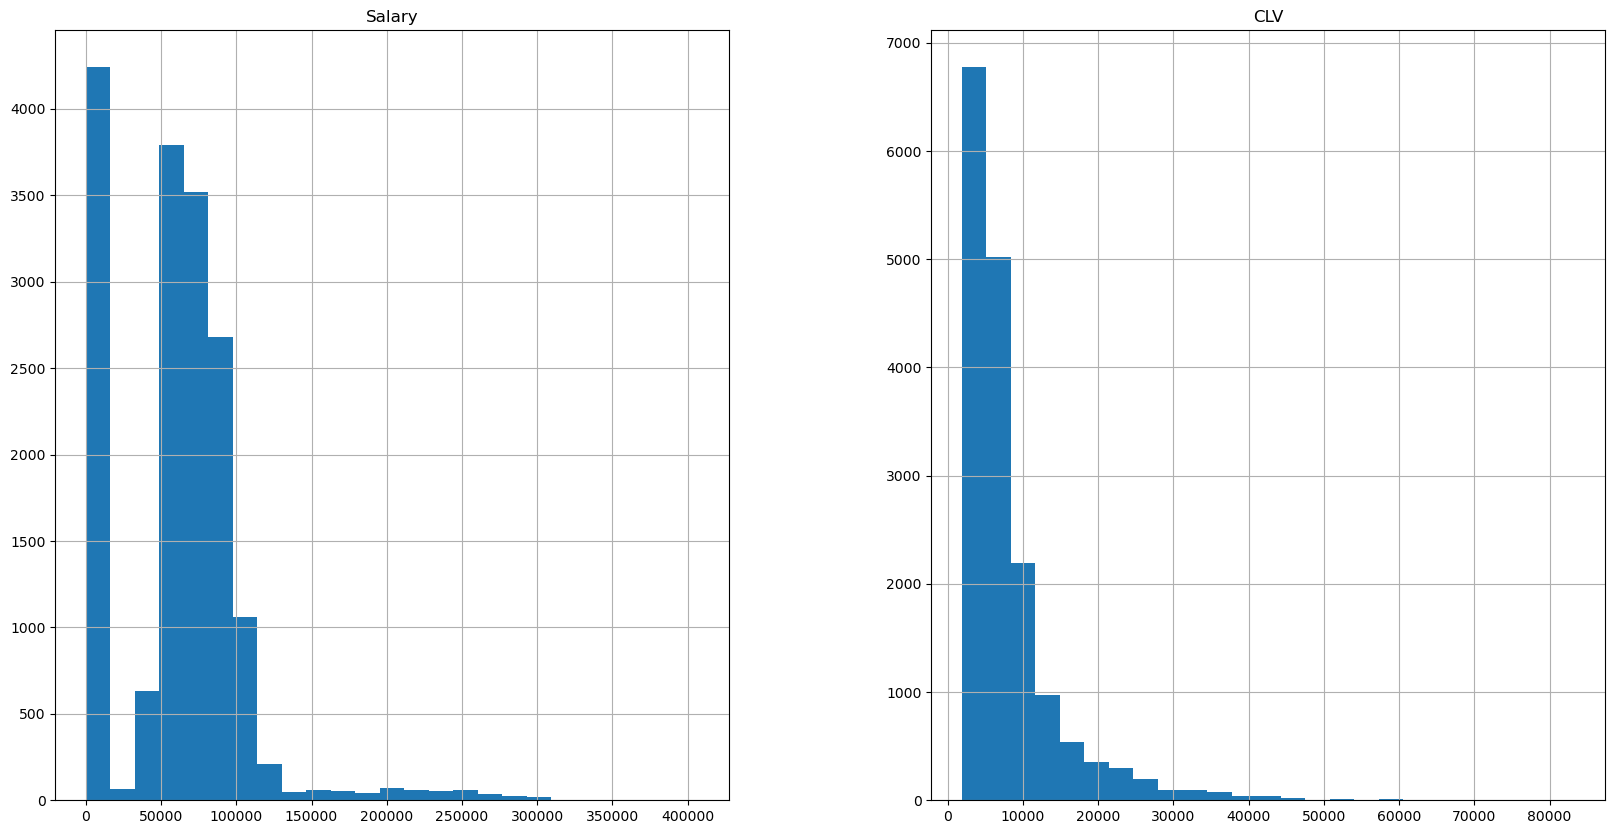

In [646]:
# se realiza un histograma para verificar la distribución de los datos en las columnas 'Salary', 'CLV'
# Customer lifetime value (CLV): son los ingresos o ganancias totales generados por un cliente durante todo el transcurso de la relación con la empresa

df_loyalty[['Salary', 'CLV']].hist(bins=25, figsize=(20,10));

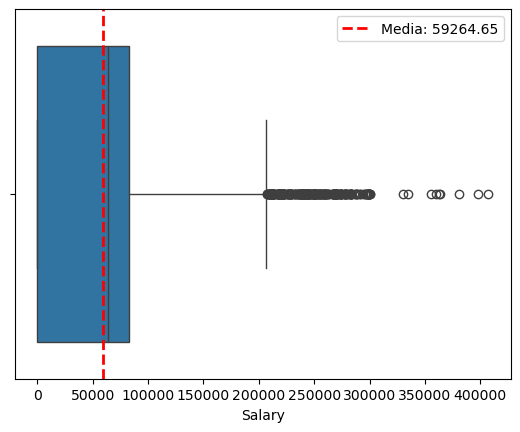

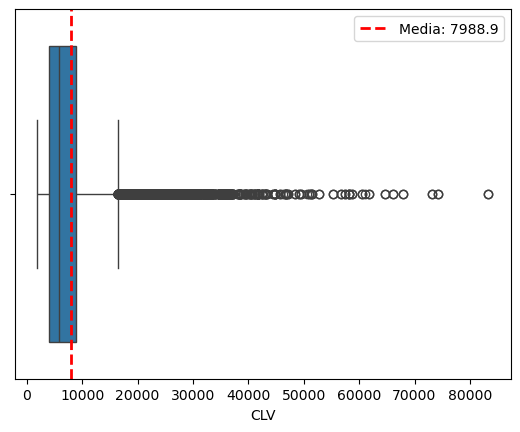

In [647]:
# usamos las columnas que nos aportan información:

for col in df_loyalty[['Salary', 'CLV']].columns:
    media_col = round(df_loyalty[col].mean(), 2) # se incorpora la media en el gráfico
    sns.boxplot(data=df_loyalty, x=col)
    plt.axvline(x=media_col, color='red', linestyle='--', linewidth=2, label=f'Media: {media_col}')
    plt.legend()
    plt.show();

In [648]:
# vemos una gran cantidad de valores atípicos en la gráfica de salario y CVL, desde los 200.000 y 20.000 respectivamente
# podemos intuir que hay una relación entre el salario y el profit que los clientes generan 
# la mayoría de los clientes tienen un salario menor a los 100.000, que generan menos de 10.000 en ganancias
# la mediana y la media se ven afectados por esos valores atípicos, siendo la media en 60K aprox. para el salario y 8K aprox. de media de ganancia

## III. Trabajamos con los DataFrame ya limpios y analisados individualmente para unirlos en un solo DataFrame
#### DataFrame: `df_complete`

In [649]:
display(df_flight.head())
display(df_loyalty.head())

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,Enero,3,0,3,1521,152,0,0
1,100102,2017,Enero,10,4,14,2030,203,0,0
2,100140,2017,Enero,6,0,6,1200,120,0,0
3,100214,2017,Enero,0,0,0,0,0,0,0
4,100272,2017,Enero,0,0,0,0,0,0,0


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236,Married,Star,3839.14,Standard,2016,Febrero,Sin data,Sin data
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,0,Divorced,Star,3839.61,Standard,2016,Marzo,Sin data,Sin data
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,0,Single,Star,3839.75,Standard,2014,Julio,2018,Enero
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,0,Single,Star,3839.75,Standard,2013,Febrero,Sin data,Sin data
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495,Married,Star,3842.79,Standard,2014,Octubre,Sin data,Sin data


In [650]:
# unimos por 'Loyalty Number', usando la funcion merge para conservar las filas que coinciden

df_completo = df_loyalty.merge(df_flight, on='Loyalty Number')
df_completo.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236,Married,Star,3839.14,Standard,2016,Febrero,Sin data,Sin data,2017,Enero,0,0,0,0,0,0,0
1,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236,Married,Star,3839.14,Standard,2016,Febrero,Sin data,Sin data,2017,Febrero,3,0,3,2823,282,0,0
2,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236,Married,Star,3839.14,Standard,2016,Febrero,Sin data,Sin data,2017,Marzo,0,0,0,0,0,0,0
3,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236,Married,Star,3839.14,Standard,2016,Febrero,Sin data,Sin data,2017,Abril,0,0,0,0,0,0,0
4,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236,Married,Star,3839.14,Standard,2016,Febrero,Sin data,Sin data,2018,Octubre,6,2,8,3352,335,465,38


In [651]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403760 entries, 0 to 403759
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               403760 non-null  int64  
 1   Country                      403760 non-null  object 
 2   Province                     403760 non-null  object 
 3   City                         403760 non-null  object 
 4   Postal Code                  403760 non-null  object 
 5   Gender                       403760 non-null  object 
 6   Education                    403760 non-null  object 
 7   Salary                       403760 non-null  int32  
 8   Marital Status               403760 non-null  object 
 9   Loyalty Card                 403760 non-null  object 
 10  CLV                          403760 non-null  float64
 11  Enrollment Type              403760 non-null  object 
 12  Enrollment Year              403760 non-null  object 
 13 

## IV. Visualización para hacer consultas y responder preguntas

In [652]:
# columnas que tenemos en el DataFrame completo
df_completo.columns

Index(['Loyalty Number', 'Country', 'Province', 'City', 'Postal Code',
       'Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card',
       'CLV', 'Enrollment Type', 'Enrollment Year', 'Enrollment Month',
       'Cancellation Year', 'Cancellation Month', 'Year', 'Month',
       'Flights Booked', 'Flights with Companions', 'Total Flights',
       'Distance', 'Points Accumulated', 'Points Redeemed',
       'Dollar Cost Points Redeemed'],
      dtype='object')

In [653]:
# 1. ¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?

In [654]:
# debemos crear una mascara para ordenar los meses correctamente, para una mejor visualización
orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# aplicamos usando Pandas para que ordene la categoría indicada en el orden indicado
df_completo['Month'] = pd.Categorical(df_completo['Month'], categories=orden, ordered=True)

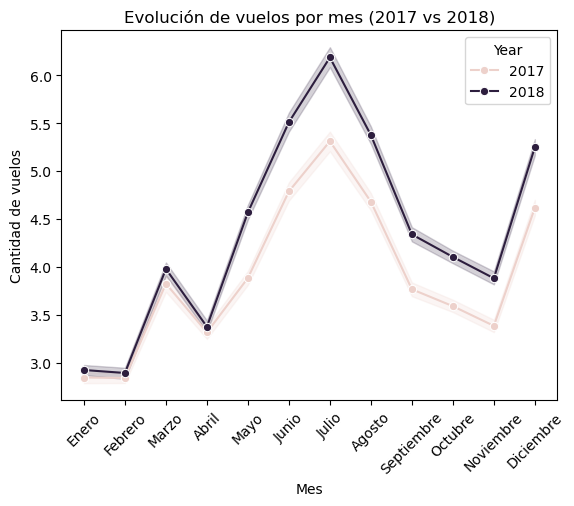

In [655]:
# se usa lineplot para ver la distribución y evolución por meses por cada año
# la librería seaborn ayuda a manejar variables categóricas (mes) y numéricas (cantidad de vuelos)

sns.lineplot(data=df_completo, x='Month', y='Flights Booked', hue='Year', marker='o')
plt.title('Evolución de vuelos por mes (2017 vs 2018)')
plt.xticks(rotation = 45)
plt.ylabel('Cantidad de vuelos')
plt.xlabel('Mes')
plt.show();

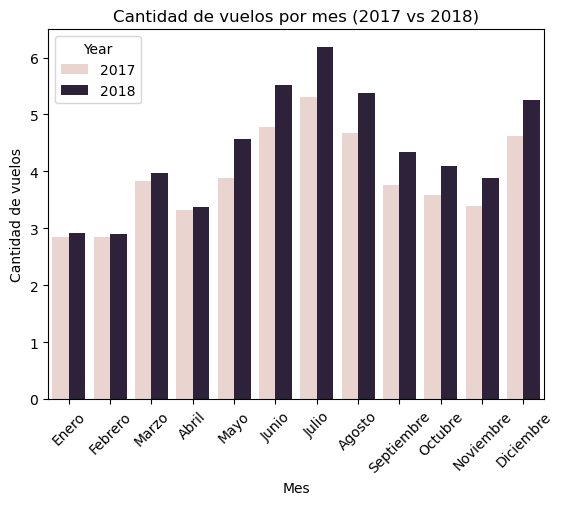

In [656]:
# visualizamos usando barplot para ver la distribución por mes, comparando cada año

sns.barplot(data=df_completo, x='Month', y='Flights Booked', errorbar=None, hue='Year')
plt.title('Cantidad de vuelos por mes (2017 vs 2018)')
plt.xticks(rotation=45)
plt.ylabel('Cantidad de vuelos')
plt.xlabel('Mes')
plt.show();

### Conclusiones:
- En 2018 se hicieron mas reservas de vuelos comparado con 2017
- Julio 2018 es el mes que mas reservas se han realizado comparado con Julio 2017
- Las reservas de vuelos distribuídas por meses, sigue el mismo patrón para ambos años, siendo Febrero el mes que menos reservas se observan

In [657]:
# 2. ¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los cliente?

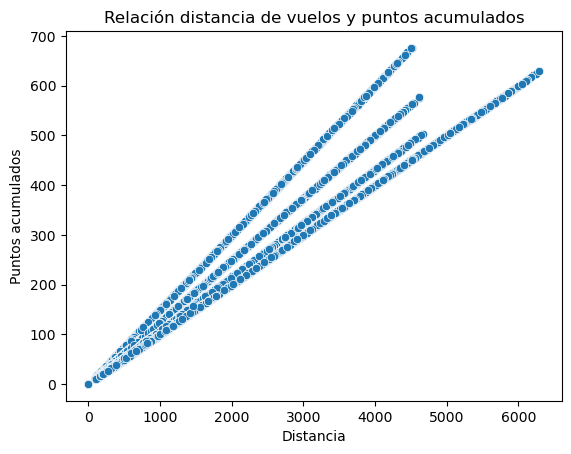

In [658]:
# se usa scatterplot para relacionar dos variables numéricas

sns.scatterplot(data = df_completo, x='Distance', y = 'Points Accumulated')
plt.title('Relación distancia de vuelos y puntos acumulados')
plt.ylabel('Puntos acumulados')
plt.xlabel('Distancia')
plt.show();

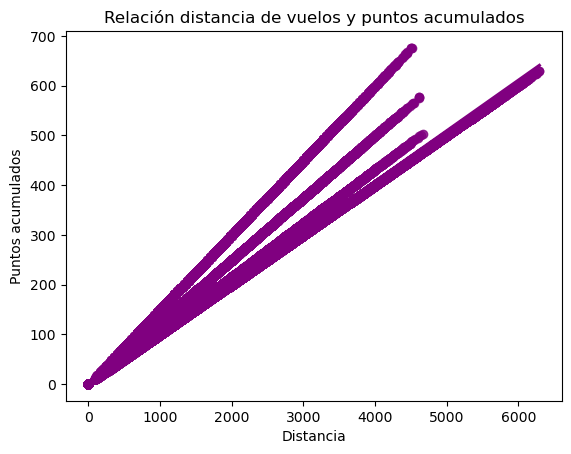

In [659]:
# también podemos visualizar la relación de dos variables numéricas usando regplot

sns.regplot(data=df_completo, x='Distance', y='Points Accumulated', color='purple')
plt.title('Relación distancia de vuelos y puntos acumulados')
plt.ylabel('Puntos acumulados')
plt.xlabel('Distancia')
plt.show();

### Conclusiones: 

- Existe una relación directa y positiva entre la distancia de vuelo y puntos acumulados, mientras mas distancia de vuelo mas puntos acumulados

In [660]:
# 3. ¿Cuál es la distribución de los clientes por provincia o estado?

In [661]:
# para visualizar los datos de mayor a menor
# agrupar por provincia y sumar los clientes totales
df_agrupado = df_completo.groupby('Province', as_index=False)['Loyalty Number'].sum()

# ordenar de mayor a menor
df_agrupado = df_agrupado.sort_values('Loyalty Number', ascending=False)

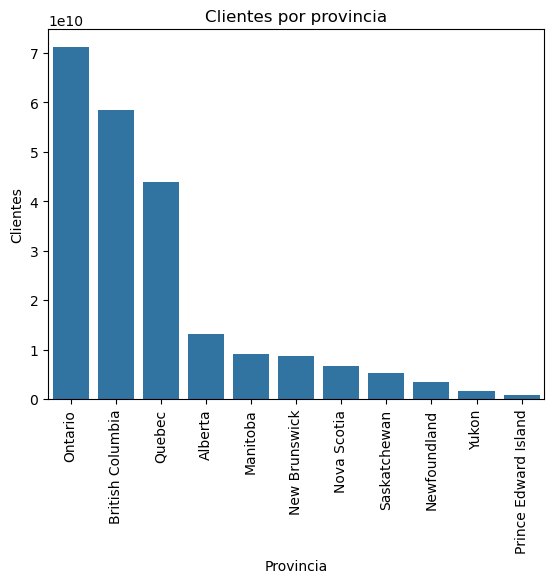

In [662]:
# visualizamos usando barplot para ver la distribución de clientes por provincia en un gráfico de barras

sns.barplot(data=df_agrupado, x='Province', y='Loyalty Number', errorbar=None)
plt.title('Clientes por provincia')
plt.xticks(rotation=90)
plt.ylabel('Clientes')
plt.xlabel('Provincia')
plt.show();

### Conclusiones:

- La provincia que mas registros se observan es 'Ontario'
- La provincia que menos clientes tiene es 'Prince Edward Island'

In [663]:
# 4. ¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?

In [664]:
# verificar las columnas del DataFrame a utilizar:
df_loyalty.columns  

Index(['Loyalty Number', 'Country', 'Province', 'City', 'Postal Code',
       'Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card',
       'CLV', 'Enrollment Type', 'Enrollment Year', 'Enrollment Month',
       'Cancellation Year', 'Cancellation Month'],
      dtype='object')

In [665]:
# verificamos el tipo de datos que tienen las columnas que queremos analizar
df_loyalty[['Salary', 'Education']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Salary     16737 non-null  int32 
 1   Education  16737 non-null  object
dtypes: int32(1), object(1)
memory usage: 196.3+ KB


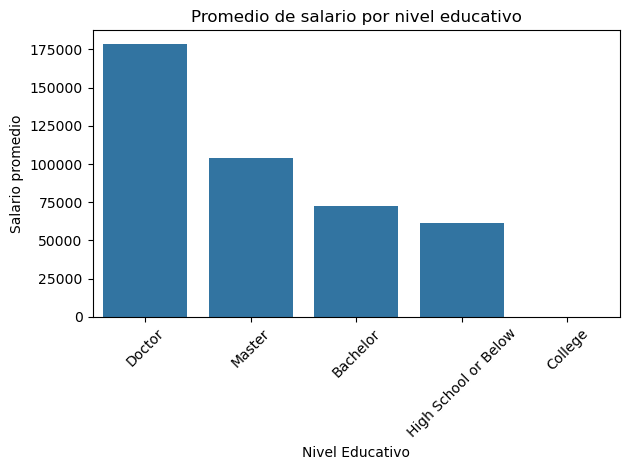

In [666]:
# ordenamos de mayor a menor, agrupando los datos por el nivel de educacion y se guarda en una variable
orden_educacion = df_loyalty.groupby('Education')['Salary'].mean().sort_values(ascending=False).index

# usamos barplot para mostrar una grafica de barras relacionando una variable numerica (Salary) con una categorica (Education)
# aplicamos el orden
sns.barplot(data=df_loyalty, x='Education', y='Salary', order=orden_educacion, errorbar=None)
plt.xticks(rotation=45)
plt.title('Promedio de salario por nivel educativo')
plt.ylabel('Salario promedio')
plt.xlabel('Nivel Educativo')
plt.tight_layout()
plt.show();

### Conclusiones:

- Los salarios mas altos en promedio pertenecen a la categoria de clientes con Doctorados
- A los clientes con un nivel de 'Collage' no registran salarios
- Se detecta que los datos 'nulos' en '0' corresponden al nivel educativo 'Collage'

In [667]:
# 5. ¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad?

In [668]:
# verificar las columnas del DataFrame a utilizar:
df_loyalty.columns  

Index(['Loyalty Number', 'Country', 'Province', 'City', 'Postal Code',
       'Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card',
       'CLV', 'Enrollment Type', 'Enrollment Year', 'Enrollment Month',
       'Cancellation Year', 'Cancellation Month'],
      dtype='object')

In [669]:
# verificamos el tipo de datos que tienen las columnas que queremos analizar
df_loyalty[['Loyalty Number', 'Loyalty Card']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Loyalty Number  16737 non-null  int64 
 1   Loyalty Card    16737 non-null  object
dtypes: int64(1), object(1)
memory usage: 261.6+ KB


In [670]:
df_loyalty['Loyalty Card'].value_counts()

Loyalty Card
Star      7637
Nova      5671
Aurora    3429
Name: count, dtype: int64

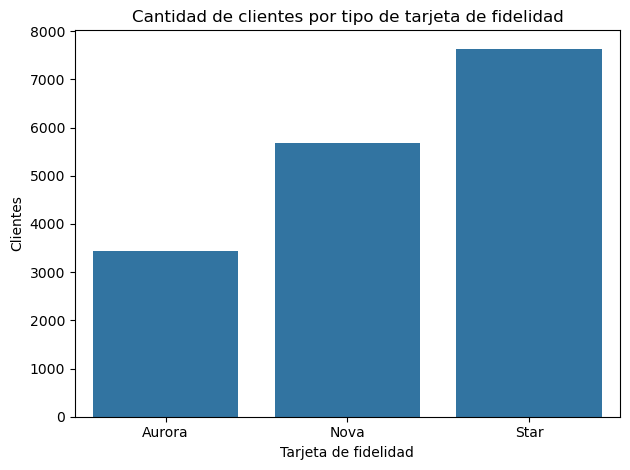

In [671]:
# agrupar y contar clientes por cada tipo de tarjeta
df_tarjetas = df_loyalty.groupby('Loyalty Card', as_index=False)['Loyalty Number'].count()

# usar el barplot para representar una variable numérica con una variable categórica
sns.barplot(data=df_tarjetas, x='Loyalty Card', y='Loyalty Number', errorbar=None)
plt.title('Cantidad de clientes por tipo de tarjeta de fidelidad')
plt.ylabel('Clientes')
plt.xlabel('Tarjeta de fidelidad')
plt.tight_layout()
plt.show();

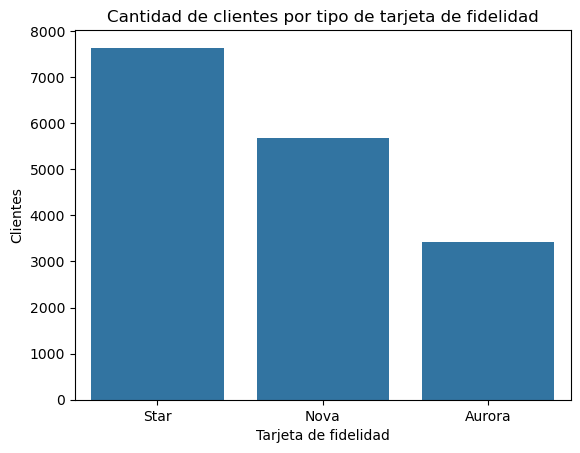

In [672]:
# sabiendo que no hay valores duplicados en los id de los clientes ('Loyalty Number'), podemos usar el countplot para 
# para contar la cantidad de veces que se repite el valor de las tarjetas de fidelidad en el DataFrame

sns.countplot(data=df_loyalty, x='Loyalty Card', order=df_loyalty['Loyalty Card'].value_counts().index)
plt.title('Cantidad de clientes por tipo de tarjeta de fidelidad')
plt.ylabel('Clientes')
plt.xlabel('Tarjeta de fidelidad')
plt.show();

### Conclusiones:

- La categoría de Tarjeta de Lealtad con mas clientes es: 'Star'
- La categoría de Tarjeta de Lealtad con menos clientes registrados en 'Aurora'

In [673]:
# 6. ¿Cómo se distribuyen los clientes según su estado civil y género?

In [674]:
df_loyalty.columns

Index(['Loyalty Number', 'Country', 'Province', 'City', 'Postal Code',
       'Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card',
       'CLV', 'Enrollment Type', 'Enrollment Year', 'Enrollment Month',
       'Cancellation Year', 'Cancellation Month'],
      dtype='object')

In [675]:
df_loyalty[['Loyalty Number', 'Gender', 'Marital Status']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Loyalty Number  16737 non-null  int64 
 1   Gender          16737 non-null  object
 2   Marital Status  16737 non-null  object
dtypes: int64(1), object(2)
memory usage: 392.4+ KB


In [676]:
df_distribucion = df_completo.groupby(['Gender', 'Marital Status'], as_index=False)['Loyalty Number'].count()
df_distribucion

,Gender,Marital Status,Loyalty Number
0,Female,Divorced,30634
1,Female,Married,117363
2,Female,Single,54760
3,Male,Divorced,30128
4,Male,Married,117482
5,Male,Single,53393


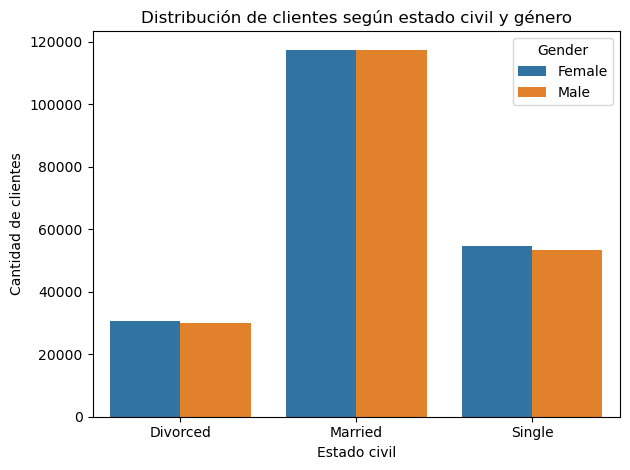

In [677]:
sns.barplot(data=df_distribucion, x='Marital Status', y='Loyalty Number', hue='Gender', errorbar=None)
plt.title('Distribución de clientes según estado civil y género')
plt.ylabel('Cantidad de clientes')
plt.xlabel('Estado civil')
plt.tight_layout()
plt.show();

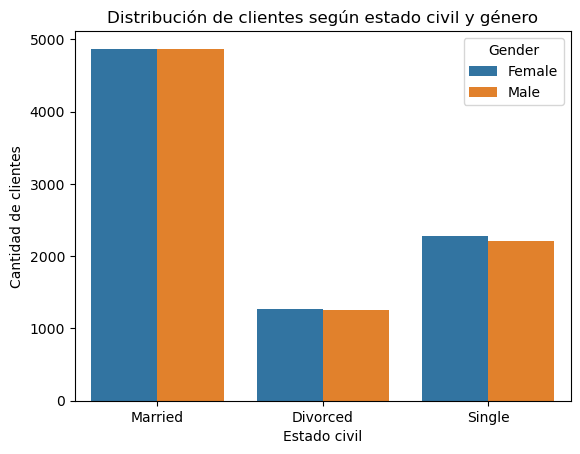

In [ ]:
# como cada fila representa un cliente, al no haber datos duplicados, tambien podemos visualizar con countplot

sns.countplot(data=df_loyalty, x='Marital Status', hue='Gender')
plt.title('Distribución de clientes según estado civil y género')
plt.xlabel('Estado civil')
plt.ylabel('Cantidad de clientes')
plt.show()

## V. Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

Se busca evaluar si existen diferencias significativas en el número de vuelos reservados según el nivel educativo de los clientes

In [679]:
# 1. Preparación de Datos: Filtra el conjunto de datos para incluir únicamente las columnas relevantes:
# 'Flights Booked' y 'Education'

In [680]:
# 2. Análisis Descriptivo: Agrupa los datos por nivel educativo y calcula estadísticas descriptivas
# básicas (como el promedio, la desviación estándar) del número de vuelos reservados para cada grupo

In [681]:
# 3. Prueba Estadística: Realiza una prueba de hipótesis para determinar si existe una diferencia significativa 
# en el número de vuelos reservados entre los diferentes niveles educativos